# ACGAN

In [1]:
import os
import tensorflow
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense,Reshape, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization,Activation,Embedding,multiply
from tensorflow.keras.layers import Conv2DTranspose,Flatten, LeakyReLU, concatenate
from tensorflow.keras.datasets import mnist

In [2]:
from tensorflow.keras.datasets import mnist
(xtr,ytr),_ = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255
ytr = to_categorical(ytr)

In [3]:
genSize = 100#Generator latent input size
num_classes = np.unique(ytr).shape[0]#Number of label
print("Latent size: {}: Label Shape: {}".format(genSize,num_classes))

Latent size: 100: Label Shape: 2


In [4]:
#Generator

def build_generator():
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    inputs = Input(shape=(100,))
    labels = Input(shape=(10,))

    inputs = [inputs, labels]
    x = concatenate(inputs, axis=1)
    x = Dense(7 * 7 * layer_filters[0])(x)
    x = Reshape((7, 7, layer_filters[0]))(x)
    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = Activation('sigmoid')(x)
    return Model(inputs, x, name='generator')

generator = build_generator()
print(generator.input_shape,generator.output_shape)
generator.summary()

[(None, 100), (None, 10)] (None, 28, 28, 1)
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6272)  

In [5]:
#Discriminator


def build_discriminator():
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    
    inputs = Input(shape=(28,28,1))

    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Flatten()(x)
    outputs = Dense(1)(x)
    outputs = Activation('sigmoid',name='RealFake')(outputs)
    layer = Dense(layer_filters[-2])(x)
    labels = Dense(10)(layer)
    labels = Activation('softmax', name='label')(labels)
    outputs = [outputs, labels]
    return Model(inputs, outputs, name='discriminator')


discriminator = build_discriminator()
print(discriminator.input_shape,discriminator.output_shape)
discriminator.summary()

(None, 28, 28, 1) [(None, 1), (None, 10)]
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 1)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   832         leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d[0][0]                     
____________________________________________

In [6]:
from gan2 import ACGAN

In [7]:
gan = ACGAN(generator=generator,discriminator=discriminator,DiscrOptimizer=Adam(learning_rate=0.0002, beta_1=0.5),GanOptimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [8]:
gan.generateBatchEval(16)
while np.unique(np.argmax(gan.evaluationInpt[1],axis=1)).shape != (10,):
    gan.generateBatchEval(16)
np.unique(np.argmax(gan.evaluationInpt[1],axis=1))
#Check if all of the 10 digits have been selected at least once

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [9]:
import matplotlib.pyplot as plt

def viewMinst(mtr,ep=None,save=True):
    """view minst"""
    path = "D:/Project/DeepLearning/GAN/ACGAN/output/Epoch_{}".format(ep)
    title = "Label = {}"#"Epoch : {}".format(ep)    
    mtr2 = np.clip(mtr[0] * 255,0,255).astype('uint8')
    lbl = np.argmax(mtr[1])   
    plt.imshow(mtr2.reshape(28,28), cmap='gray')
    plt.title('Label: {}'.format(lbl))
    if not os.path.isdir(path):
        os.mkdir(path) 
    if save == True and not ep is None:
        i = 0
        while os.path.exists(path + '/Epoch{}_{}.jpg'.format(ep,i)):
            i+=1
        plt.savefig(path + '/Epoch{}_{}.jpg'.format(ep,i))

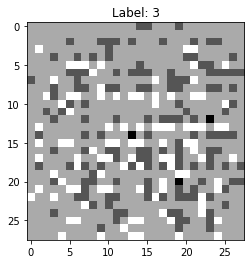

In [10]:
gan.GenerateOutputs(xtest=gan.evaluationInpt ,batchSize=16,viewFunction=viewMinst,returnArray=False,ep=0)

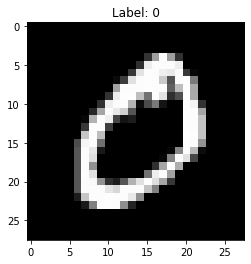

In [11]:
viewMinst([xtr[1], ytr[1]  ],ep=None,save=False)

Epoch 1/30
117/117 [==============================] - 100s 857ms/step
Discrimiator: (loss,0.4831579923629761)(RealFake_loss,0.0010683926520869136)(label_loss,0.4820896089076996)(RealFake_accuracy,1.0)(label_accuracy,0.9619140625)
 	 Adversial: (loss,0.005274565890431404)(RealFake_loss,0.0003419756831135601)(label_loss,0.004932590294629335)(RealFake_accuracy,1.0)(label_accuracy,0.998046875)
Epoch 2/30
117/117 [==============================] - 105s 898ms/step
Discrimiator: (loss,0.126554936170578)(RealFake_loss,0.0016096321633085608)(label_loss,0.12494529783725739)(RealFake_accuracy,1.0)(label_accuracy,0.9814453125)
 	 Adversial: (loss,0.0004093512543477118)(RealFake_loss,0.0003824133309535682)(label_loss,2.693791248020716e-05)(RealFake_accuracy,1.0)(label_accuracy,1.0)
Epoch 3/30
117/117 [==============================] - 107s 916ms/step
Discrimiator: (loss,0.6781196594238281)(RealFake_loss,0.5507630109786987)(label_loss,0.1273566633462906)(RealFake_accuracy,0.728515625)(label_accuracy

Epoch 22/30
117/117 [==============================] - 109s 931ms/step
Discrimiator: (loss,0.736047625541687)(RealFake_loss,0.694732666015625)(label_loss,0.04131495952606201)(RealFake_accuracy,0.5244140625)(label_accuracy,0.9931640625)
 	 Adversial: (loss,0.6364108920097351)(RealFake_loss,0.6344609260559082)(label_loss,0.0019499677000567317)(RealFake_accuracy,0.71875)(label_accuracy,1.0)
Epoch 23/30
117/117 [==============================] - 108s 924ms/step
Discrimiator: (loss,0.7322542071342468)(RealFake_loss,0.6972651481628418)(label_loss,0.03498908132314682)(RealFake_accuracy,0.50390625)(label_accuracy,0.994140625)
 	 Adversial: (loss,0.6407589912414551)(RealFake_loss,0.6353049874305725)(label_loss,0.005454020109027624)(RealFake_accuracy,0.6875)(label_accuracy,1.0)
Epoch 24/30
117/117 [==============================] - 108s 923ms/step
Discrimiator: (loss,0.715584397315979)(RealFake_loss,0.6789386868476868)(label_loss,0.03664570674300194)(RealFake_accuracy,0.5830078125)(label_accurac

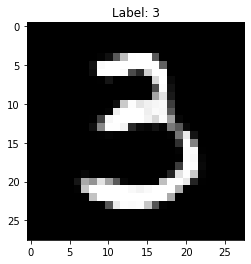

In [12]:
gan.train([xtr,ytr],batch_size=1024,epoch=30,outputTr=viewMinst,evalStep=1,pathSave='D:/Project/DeepLearning/GAN/ACGAN/save/')

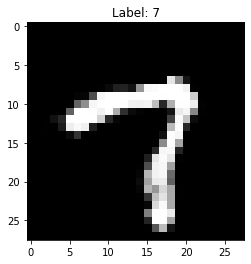

In [13]:
gan.GenerateOutputs(batchSize=1,viewFunction=viewMinst,returnArray=False)